In [5]:
# Import packages

from __future__ import print_function, division
from IPython.display import display, HTML

import pandas as pd
import numpy as np

from tqdm import tqdm

# import statsmodels.api as sm
from statsmodels import tsa
import statsmodels.api as sm
from datetime import date, datetime, timedelta
import copy
import scipy as sp
from scipy.optimize import fsolve
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import interpolate
import datetime

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

# Plotting and display options
np.set_printoptions(precision=5)
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# pandas settings
pd.set_option('precision', 6)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# this allows plots to appear directly in the notebook
get_ipython().magic(u'matplotlib inline')


C:\Users\Yi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dividend = pd.read_csv('dividend.csv')
stock = pd.read_csv('stock.csv')

In [4]:
dividend.head()

,PERMNO,DISTCD,DIVAMT,EXDT
0,10000,nan,nan,nan
1,10001,1232.000000,0.095000,19860310.000000
2,10001,1232.000000,0.105000,19860609.000000
3,10001,1232.000000,0.105000,19860908.000000
4,10001,1232.000000,0.105000,19861208.000000


In [5]:
stock.head()

,PERMNO,date,EXCHCD,TICKER,COMNAM,NAICS,PRC,VOL
0,10000,19860106,nan,NaN,NaN,nan,nan,nan
1,10000,19860107,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.562500,1000.000000
2,10000,19860108,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,12800.000000
3,10000,19860109,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,1400.000000
4,10000,19860110,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,8500.000000


In [20]:
store = stock.dropna(axis=0, subset=['PERMNO','date','PRC','VOL'])

In [54]:
DIVIDEND = dividend.dropna(axis=0, how='any')

In [55]:
DIVIDEND.head()

,PERMNO,DISTCD,DIVAMT,EXDT
1,10001,1232.000000,0.095000,19860310.000000
2,10001,1232.000000,0.105000,19860609.000000
3,10001,1232.000000,0.105000,19860908.000000
4,10001,1232.000000,0.105000,19861208.000000
5,10001,1232.000000,0.105000,19870309.000000


In [56]:
STOCK = store[~store['EXCHCD'].isin([0,-1,-2])]

In [57]:
STOCK['EXCHCD'].unique()

array([  3.,   2.,   1.,   4.,  31.,  33.,  32.])

In [58]:
STOCK.head()

,PERMNO,date,EXCHCD,TICKER,COMNAM,NAICS,PRC,VOL
1,10000,19860107,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.562500,1000.000000
2,10000,19860108,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,12800.000000
3,10000,19860109,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,1400.000000
4,10000,19860110,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,8500.000000
5,10000,19860113,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.625000,5450.000000


In [59]:
NAICS = STOCK['NAICS'].dropna(axis=0, how='all')

In [61]:
NAICS.apply(lambda x: int(x/10000)).unique()

array([22, 52, 55, 33, 32, 31, 44, 21, 53, 71, 62, 51, 54, 42, 56, 48, 23,
       45, 61, 11, 72, 49, 81, 92, 99, 67])

In [68]:
def merge_data(df1, df2):
    df1['key'] = df1['PERMNO'] * 100000000 + df1['date']
    df2['key'] = df2['PERMNO'] * 100000000 + df2['EXDT']
    df1['key'] = df1['key'].apply(lambda x: int(x))
    df2['key'] = df2['key'].apply(lambda x: int(x))
    result = df1.merge(df2, left_on='key', right_on='key', how='left')
    return result

### Paper Replication

In [7]:
MERGE = pd.read_csv('T:/Berkeley/courses/230N_AFP/data/merge_result_1.csv',index_col=0, header=0)
MERGE.head()

,date,EXCHCD,TICKER,COMNAM,NAICS,PRC,VOL,PERMNO,key,DISTCD,DIVAMT,EXDT
0,19860107,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.562500,1000.000000,10000,1000019860107,nan,nan,nan
1,19860108,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,12800.000000,10000,1000019860108,nan,nan,nan
2,19860109,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,1400.000000,10000,1000019860109,nan,nan,nan
3,19860110,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.500000,8500.000000,10000,1000019860110,nan,nan,nan
4,19860113,3.000000,OMFGA,OPTIMUM MANUFACTURING INC,nan,-2.625000,5450.000000,10000,1000019860113,nan,nan,nan


In [8]:
MERGE = MERGE.dropna(axis=0, subset=['PERMNO','date','PRC','VOL'])

In [9]:
def regression_prep(df):
    price_change = []
    dividend = []
    ex_day = []
    ex_day_return = []
    div_yield = []
    price_ratio = []
    N = len(df.index)
    for i in tqdm(np.arange(1, N)):
        current_company = df['PERMNO'].iloc[i]
        div = df['DIVAMT'].iloc[i]
        if div > 0:
            if df['PERMNO'].iloc[i-1] == current_company:
                price_today = abs(df['PRC'].iloc[i])
                price_yes = abs(df['PRC'].iloc[i-1])
                price_change.append(price_today - price_yes)
                dividend.append(div)
                ex_day.append(df['date'].iloc[i])
                ex_day_return.append((price_today - price_yes + div) / price_yes)
                div_yield.append(div / price_yes)
                price_ratio.append((price_yes - price_today) / div)
    d = {'ex-dividend date':ex_day, 'price change': price_change, 'dividend':dividend,
         'ex-day return':ex_day_return, 'dividend yield': div_yield, 'price ratio':price_ratio}
    d = pd.DataFrame(d, columns=['ex-dividend date','price change','dividend','ex-day return','dividend yield','price ratio'])
    return d

In [10]:
output = regression_prep(MERGE)

100%|█████████████████████████████████████████████████████████████████████| 9517932/9517932 [06:58<00:00, 22747.81it/s]


In [11]:
output.head()

,ex-dividend date,price change,dividend,ex-day return,dividend yield,price ratio
0,19860310,0.000000,0.095000,0.015200,0.015200,0.000000
1,19860609,0.000000,0.105000,0.016970,0.016970,0.000000
2,19860908,0.250000,0.105000,0.054615,0.016154,2.380952
3,19861208,0.000000,0.105000,0.016154,0.016154,0.000000
4,19870309,0.062500,0.105000,0.027629,0.017320,0.595238


In [13]:
output['2003 Tax Reform'] = output['ex-dividend date'].apply(lambda x: 0 if x < 20030528 else 1)
output.head()

,ex-dividend date,price change,dividend,ex-day return,dividend yield,price ratio,2003 Tax Reform
0,19860310,0.000000,0.095000,0.015200,0.015200,0.000000,0
1,19860609,0.000000,0.105000,0.016970,0.016970,0.000000,0
2,19860908,0.250000,0.105000,0.054615,0.016154,2.380952,0
3,19861208,0.000000,0.105000,0.016154,0.016154,0.000000,0
4,19870309,0.062500,0.105000,0.027629,0.017320,0.595238,0


In [14]:
output = output.sort_values(by='dividend yield', ascending=True)
output.head()

,ex-dividend date,price change,dividend,ex-day return,dividend yield,price ratio,2003 Tax Reform
66067,20061226,0.230000,0.000100,0.005616,0.000002,2300.000000,1
33514,20110627,0.435000,0.000260,0.009144,0.000005,1673.076923,1
34677,20151222,0.245000,0.000320,0.005870,0.000008,765.625000,1
55718,20160318,0.020000,0.000190,0.000836,0.000008,105.263158,1
33999,20131220,0.130000,0.000280,0.004900,0.000011,464.285714,1


In [15]:
print(np.sum(output['2003 Tax Reform']),output.shape[0]-np.sum(output['2003 Tax Reform']))

34292 37444


In [30]:
quintile_length = int(output.shape[0]/5)
j = 1
desc = pd.DataFrame()
for i in range(0,output.shape[0]-quintile_length,quintile_length):
    tab = output.iloc[i:i+quintile_length]
    temp = {'mean dividend yield':np.mean(tab['dividend yield']), 'mean price ratio (full sample)':np.mean(tab['price ratio']), 
            'mean price ratio (after 2003)':np.mean(tab.where(tab['2003 Tax Reform']==1)['price ratio']),
             'mean price ratio (before 2003)':np.mean(tab.where(tab['2003 Tax Reform']==0)['price ratio'])}     
    desc = desc.append(pd.DataFrame(temp,index=[str(j)]))
    j = j+1
desc

,mean dividend yield,mean price ratio (after 2003),mean price ratio (before 2003),mean price ratio (full sample)
1,0.001938,0.658877,0.858046,0.719487
2,0.004399,0.817214,0.648536,0.737231
3,0.006712,0.856084,0.503279,0.667669
4,0.009745,0.827969,0.547136,0.648061
5,0.022174,0.902539,0.703556,0.771877


In [29]:
Y = output.iloc[0:quintile_length]['ex-day return']
X = output.iloc[0:quintile_length][['dividend yield', '2003 Tax Reform']]
X['product'] = X['dividend yield'] * X['2003 Tax Reform']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ex-day return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.702
Date:                Tue, 06 Feb 2018   Prob (F-statistic):             0.0439
Time:                        16:53:20   Log-Likelihood:                 35689.
No. Observations:               14347   AIC:                        -7.137e+04
Df Residuals:                   14343   BIC:                        -7.134e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0011      0.001     -1.285      0.199      -0.003       0.001
dividend yield      0.7997      0.383      2.087      0.037       0.049       1.551
2003 Tax Reform     0.0006      0.001      0.649      0.516      -0.001       0.003
product            -0.3952      0.448     -0.883      0.377      -1.272       0.482
==============================================================================
Omnibus:                     6983.156   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1286664.939
Skew:                          -1.240   Prob(JB):                         0.00
Kurtosis:                      49.327   Cond. No.                     4.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
Y = output.iloc[quintile_length*4:quintile_length*5]['ex-day return']
X = output.iloc[quintile_length*4:quintile_length*5][['dividend yield', '2003 Tax Reform']]
X['product'] = X['dividend yield'] * X['2003 Tax Reform']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ex-day return   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     229.5
Date:                Tue, 06 Feb 2018   Prob (F-statistic):          2.05e-145
Time:                        16:53:53   Log-Likelihood:                 28686.
No. Observations:               14347   AIC:                        -5.736e+04
Df Residuals:                   14343   BIC:                        -5.733e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0015      0.000      3.833      0.000       0.001       0.002
dividend yield      0.2216      0.009     23.749      0.000       0.203       0.240
2003 Tax Reform    -0.0024      0.001     -3.510      0.000      -0.004      -0.001
product            -0.1085      0.016     -6.726      0.000      -0.140      -0.077
==============================================================================
Omnibus:                    18969.045   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         43219553.085
Skew:                           6.558   Prob(JB):                         0.00
Kurtosis:                     271.564   Cond. No.                         67.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
Y = output.where((output['2003 Tax Reform']==0)&(output['dividend yield']<0.4)).dropna()['ex-day return']
X = output.where((output['2003 Tax Reform']==0)&(output['dividend yield']<0.4)).dropna()['dividend yield']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ex-day return   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     432.1
Date:                Tue, 06 Feb 2018   Prob (F-statistic):           1.95e-95
Time:                        16:54:01   Log-Likelihood:                 81773.
No. Observations:               37420   AIC:                        -1.635e+05
Df Residuals:                   37418   BIC:                        -1.635e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0008      0.000      4.024      0.000       0.000       0.001
dividend yield     0.2874      0.014     20.788      0.000       0.260       0.314
==============================================================================
Omnibus:                    13439.539   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1729131.541
Skew:                          -0.694   Prob(JB):                         0.00
Kurtosis:                      36.273   Cond. No.                         98.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

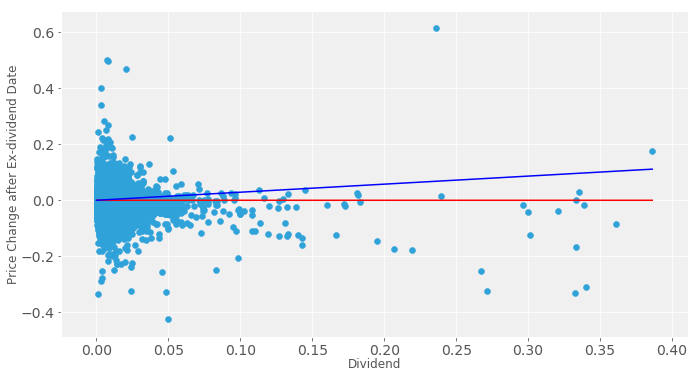

In [33]:
beta = results.params[1]
plt.figure(figsize=(10,6))   
plt.subplot(1,1,1)
plt.scatter(X['dividend yield'], -Y)
plt.xlabel('Dividend', fontsize=12)
plt.ylabel('Price Change after Ex-dividend Date', fontsize=12)
plt.plot(X['dividend yield'], np.repeat(0,X.shape[0]), color='red')
plt.plot(X['dividend yield'], beta*X['dividend yield'], color='blue')

In [34]:
Y = output.where((output['2003 Tax Reform']==1)&(output['dividend yield']<0.4)).dropna()['ex-day return']
X = output.where((output['2003 Tax Reform']==1)&(output['dividend yield']<0.4)).dropna()['dividend yield']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ex-day return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.294
Date:                Tue, 06 Feb 2018   Prob (F-statistic):             0.0214
Time:                        16:54:23   Log-Likelihood:                 85143.
No. Observations:               34281   AIC:                        -1.703e+05
Df Residuals:                   34279   BIC:                        -1.703e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0008      0.000      5.827      0.000       0.001       0.001
dividend yield     0.0225      0.010      2.301      0.021       0.003       0.042
==============================================================================
Omnibus:                    41938.193   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        147186920.920
Skew:                           5.474   Prob(JB):                         0.00
Kurtosis:                     323.820   Cond. No.                         89.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

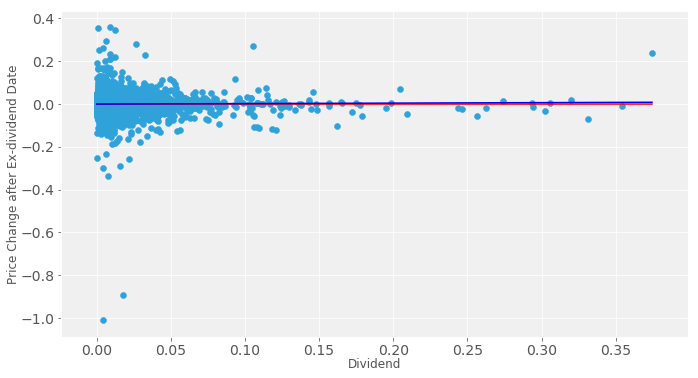

In [35]:
beta = results.params[1]
plt.figure(figsize=(10,6))   
plt.subplot(1,1,1)
plt.scatter(X['dividend yield'], -Y)
plt.xlabel('Dividend', fontsize=12)
plt.ylabel('Price Change after Ex-dividend Date', fontsize=12)
plt.plot(X['dividend yield'], np.repeat(0,X.shape[0]), color='red')
plt.plot(X['dividend yield'], beta*X['dividend yield'], color='blue')

In [118]:
Y = output.where((output['2003 Tax Reform']==1)&(output['dividend yield']<0.4)).dropna()['price ratio']
X = output.where((output['2003 Tax Reform']==1)&(output['dividend yield']<0.4)).dropna()['dividend yield']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price ratio   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     9982.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:56:03   Log-Likelihood:                 85143.
No. Observations:               34281   AIC:                        -1.703e+05
Df Residuals:                   34279   BIC:                        -1.703e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0008      0.000     -5.827      0.000      -0.001      -0.001
dividend yield     0.9775      0.010     99.911      0.000       0.958       0.997
==============================================================================
Omnibus:                    41938.193   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        147186920.920
Skew:                          -5.474   Prob(JB):                         0.00
Kurtosis:                     323.820   Cond. No.                         89.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

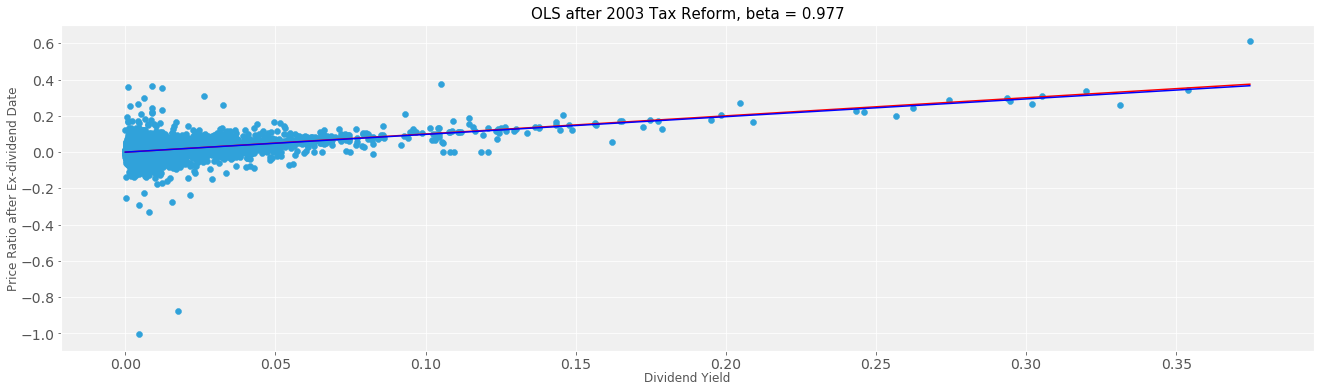

In [119]:
beta = results.params[1]
plt.figure(figsize=(20,6))   
plt.subplot(1,1,1)
plt.scatter(X['dividend yield'], Y)
plt.xlabel('Dividend Yield', fontsize=12)
plt.ylabel('Price Ratio after Ex-dividend Date', fontsize=12)
plt.title('OLS after 2003 Tax Reform' + ', beta = ' + str(round(beta,3)),fontsize=15)
plt.plot(X['dividend yield'], X['dividend yield'], color='red')
plt.plot(X['dividend yield'], beta*X['dividend yield'], color='blue')

In [120]:
Y = output.where((output['2003 Tax Reform']==0)&(output['dividend yield']<0.4)).dropna()['price ratio']
X = output.where((output['2003 Tax Reform']==0)&(output['dividend yield']<0.4)).dropna()['dividend yield']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price ratio   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2657.
Date:                Tue, 06 Feb 2018   Prob (F-statistic):               0.00
Time:                        13:56:28   Log-Likelihood:                 81773.
No. Observations:               37420   AIC:                        -1.635e+05
Df Residuals:                   37418   BIC:                        -1.635e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0008      0.000     -4.024      0.000      -0.001      -0.000
dividend yield     0.7126      0.014     51.542      0.000       0.686       0.740
==============================================================================
Omnibus:                    13439.539   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1729131.541
Skew:                           0.694   Prob(JB):                         0.00
Kurtosis:                      36.273   Cond. No.                         98.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

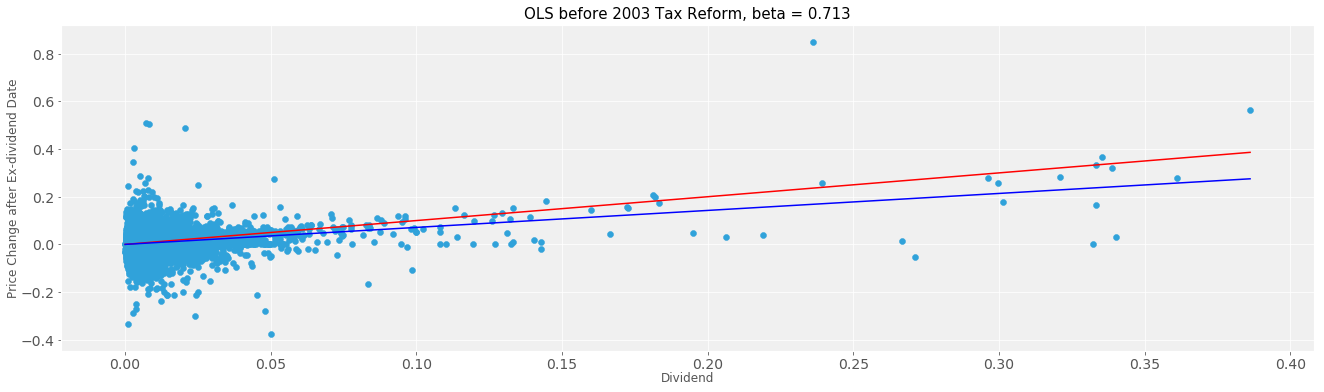

In [121]:
beta = results.params[1]
plt.figure(figsize=(20,6))   
plt.subplot(1,1,1)
plt.scatter(X['dividend yield'], Y)
plt.xlabel('Dividend', fontsize=12)
plt.ylabel('Price Change after Ex-dividend Date', fontsize=12)
plt.title('OLS before 2003 Tax Reform' + ', beta = ' + str(round(beta,3)),fontsize=15)
plt.plot(X['dividend yield'], X['dividend yield'], color='red')
plt.plot(X['dividend yield'], beta*X['dividend yield'], color='blue')